## TENSOR FLOW: FOREIGN RATE EXCHANGE

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data Wrangling

In [2]:
def wrangle(filepath, currency):
    #Import data
    df = pd.read_excel(filepath, na_values="ND")
    
    #Selecting data for time_series analysis
    df_time_series = df[["Time Serie", currency]]
    
    #Changing country-countrycurrency-per USD column to currency_per_USD 
    currency_per_USD = df.columns[list(df.columns).index(currency)].split(" - ")[1]
    
    #Renaming columns
    df_time_series.rename(columns={"Time Serie" : "Date", currency : currency_per_USD}, inplace=True)
    
    #Changing date dtype from object to datetime, sorting date values, and setting date as index
    df_time_series["Date"] = pd.to_datetime(df_time_series["Date"])
    df = df_time_series.sort_values(by="Date")
    df.set_index("Date", inplace = True)
    
    #Using forward fill method to replace NaN
    df[currency_per_USD] = df[currency_per_USD].fillna(method="ffill")
    
    #Creating a lag feature
    df[currency_per_USD + "-L1"] = df[currency_per_USD].shift(1)
    
    #Drop missing values
    df.dropna(inplace=True)
    
    return df

In [3]:
df_yuan_USD = wrangle("Foreign_Exchange_Rates.xlsx", "CHINA - YUAN/US$")
df_yuan_USD.head()

C:\Users\owner\AppData\Local\Temp\ipykernel_8824\224743042.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_series.rename(columns={"Time Serie" : "Date", currency : currency_per_USD}, inplace=True)
C:\Users\owner\AppData\Local\Temp\ipykernel_8824\224743042.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_series["Date"] = pd.to_datetime(df_time_series["Date"])


,YUAN/US$,YUAN/US$-L1
Date,,
2000-01-04,8.2799,8.2798
2000-01-05,8.2798,8.2799
2000-01-06,8.2797,8.2798
2000-01-07,8.2794,8.2797
2000-01-10,8.2794,8.2794


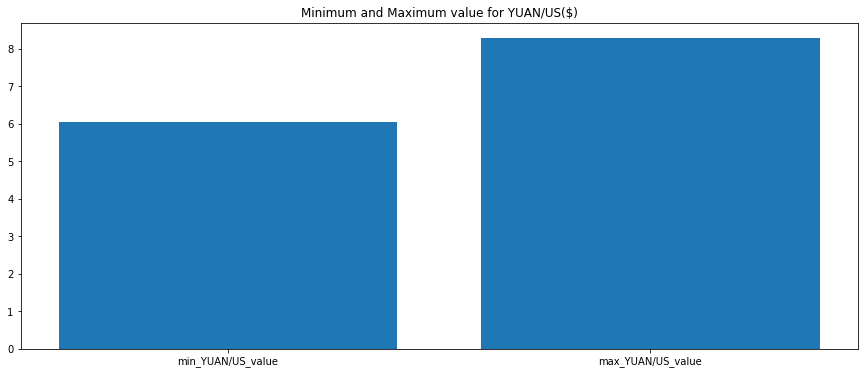

In [127]:
plt.figure(figsize=(15,6))
min_value = df_yuan_USD["YUAN/US$"].describe()["min"]
max_value = df_yuan_USD["YUAN/US$"].describe()["max"]
a = pd.Series({"min_YUAN/US_value": min_value, "max_YUAN/US_value": max_value}, index=None)
plt.title("Minimum and Maximum value for YUAN/US($)")
plt.bar(x=a.index, height=a)
plt.savefig("auto7.png");

In [116]:
df_yuan_USD.isnull().sum()

YUAN/US$       0
YUAN/US$-L1    0
dtype: int64

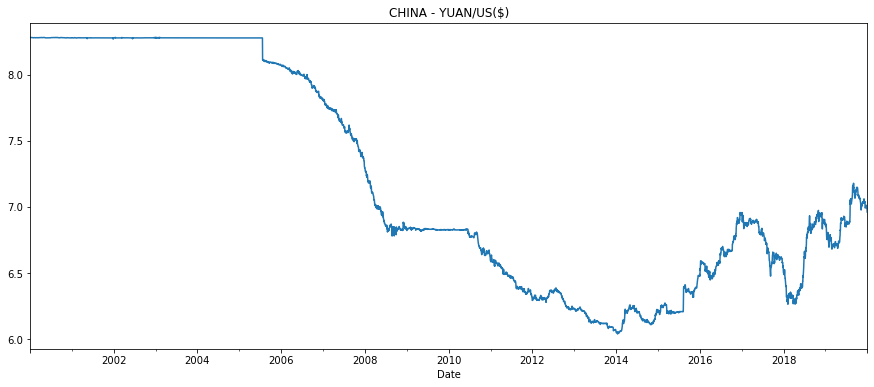

In [5]:
plt.figure(figsize=(15,6))
df_yuan_USD["YUAN/US$"].plot()
plt.title("CHINA - YUAN/US($)");

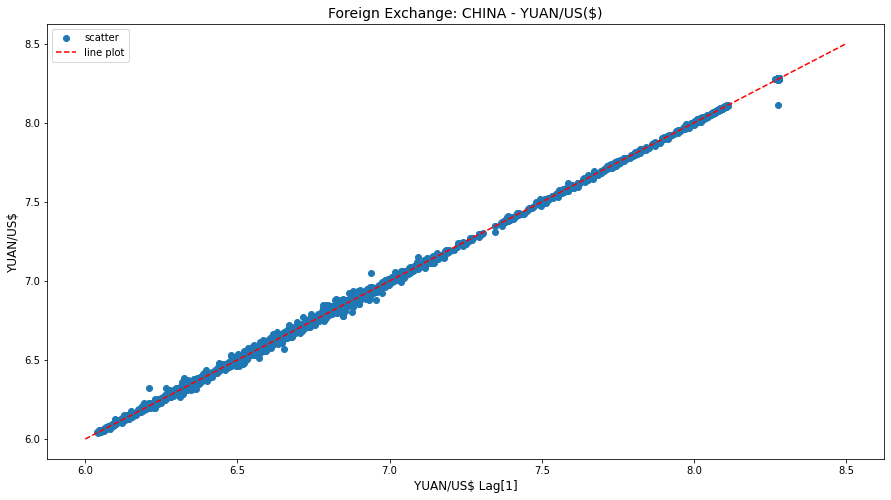

In [81]:
fig, ax = plt.subplots(figsize=(15,8))

ax.scatter(x=df_yuan_USD["YUAN/US$-L1"], y=df_yuan_USD["YUAN/US$"], label="scatter")
ax.plot([6, 8.5], [6, 8.5], linestyle="--", color="red", label="line plot")
plt.xlabel("YUAN/US$ Lag[1]", fontsize=12)
plt.ylabel("YUAN/US$", fontsize=12)
plt.title("Foreign Exchange: CHINA - YUAN/US($)", fontsize=14)
plt.legend()
plt.savefig("auto1.png");

### Linear Regression model

In [7]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression() 

In [56]:
def model_building(df, build_model):
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    
    #Split dataset
    X = df.drop(columns=df.columns[0])
    y = df[df.columns[0]]
   
    #Train-test-split
    cut_off = int(len(X)*0.8)
    X_train, y_train = X.iloc[:cut_off], y.iloc[:cut_off]
    X_test, y_test = X.iloc[cut_off:], y.iloc[cut_off:]
    
    #Baseline model
    y_mean = y_train.mean()
    y_pred_baseline = [y_mean] * len(y_train)
    assert len(y_pred_baseline) == len(y_train)
    mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
    print(f"Baseline MAE is {mae_baseline.round(2)}")
    print()
    
    #Instatiate model and fit
    model = build_model
    model.fit(X_train, y_train)
    
    #MAE for train dataset
    y_pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    #Model evaluation: Performance metrics
    y_pred_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rss = np.sum(np.square(y_test - y_pred_test))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_score = r2_score(y_test, y_pred_test)
    
    print(f"MAE for {model} for training_mae {mae_train.round(6)} and test_mae {mae_test.round(6)}")
    print(f"RSS for {model} is {rss.round(6)}, RSME is {rmse.round(6)}, and r2_score is {r2_score.round(6)}")
    print()
    
    #Communicating Results: intercept and coefficient  
    intercept = round(model.intercept_, 6)
    coefficient = round(model.coef_[0], 6)
    print(f"{df.columns[0]} = {intercept} + {coefficient} * {df_yuan_USD.columns[1]}")
    print()
    
    data_pred_test = pd.DataFrame(
                            {"y_test": y_test,
                             "y_pred": y_pred_test})
    
    #Plot time series prediction
    import plotly.express as px
    fig = px.line(data_pred_test, labels={'value': df.columns[0]}, title="Time Series Prediction of China - Yuan/US ($)")

    return fig

In [57]:
linear_model = model_building(df_yuan_USD, linear)
linear_model

Baseline MAE is 0.83

MAE for LinearRegression() for training_mae 0.003196 and test_mae 0.010836
RSS for LinearRegression() is 0.27367, RSME is 0.016191, and r2_score is 0.994079

YUAN/US$ = 7.6e-05 + 0.999931 * YUAN/US$-L1



In [58]:
mae_test = 0.010836
rss = 0.27367
rmse = 0.016191
r2_score = 0.994079

### AR model

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import plotly.express as px

In [11]:
X = df_yuan_USD.drop(columns=df_yuan_USD.columns[0])
y = df_yuan_USD[df_yuan_USD.columns[0]]
   
#Train-test-split
cut_off = int(len(X)*0.8)
X_train, y_train = X.iloc[:cut_off], y.iloc[:cut_off]
X_test, y_test = X.iloc[cut_off:], y.iloc[cut_off:]

In [88]:
def wrangle_1(filepath, currency):
    #Import data
    df = pd.read_excel(filepath, na_values="ND").rename(columns={"Time Serie":"Date"}).set_index("Date")
    
    #Changing date dtype from object to datetime, sorting date values, and setting date as index
    df.index = pd.to_datetime(df.index).sort_values()
    
    
    #Selecting data for time_series analysis
    df = df[currency]
    
    
    #Using forward fill method to replace NaN
    df = df.fillna(method="ffill")
    
    return df

In [93]:
y = wrangle_1("Foreign_Exchange_Rates.xlsx", "CHINA - YUAN/US$")
y.head()

Date
2000-01-03    8.2798
2000-01-04    8.2799
2000-01-05    8.2798
2000-01-06    8.2797
2000-01-07    8.2794
Name: CHINA - YUAN/US$, dtype: float64

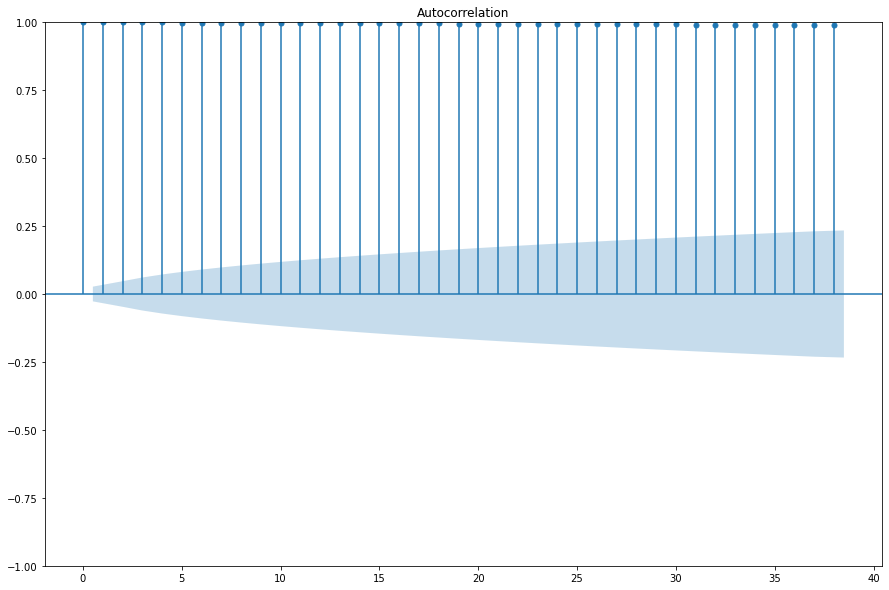

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_acf(y, ax=ax);

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



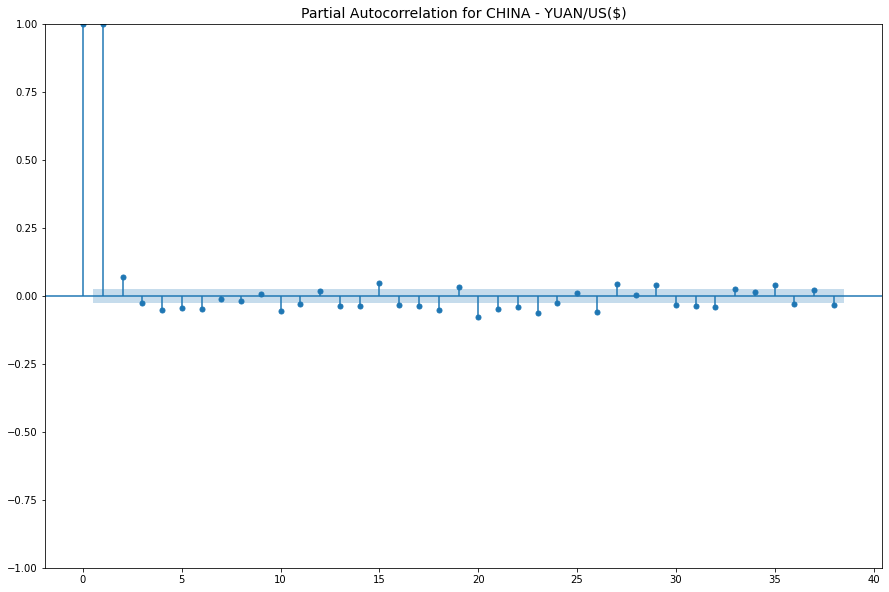

In [83]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_pacf(y, ax=ax)
plt.title("Partial Autocorrelation for CHINA - YUAN/US($)", fontsize=14)
plt.savefig("auto2.png");

From the plot_acf and plot_pacf above we can assume that lag(p) = 35

In [16]:
int(len(y)*0.8)

4173

In [17]:
len(y)

5217

In [95]:
y_train = y.iloc[:int(len(y)*0.8)]
y_test = y.iloc[int(len(y)*0.8):]

In [96]:
model = AutoReg(y_train, lags=35).fit()
y_pred = model.predict().dropna()

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



In [20]:
len(y_pred) + 36

4174

In [97]:
training_mae = mean_absolute_error(y_train.iloc[35:], y_pred)
training_mae

0.0031901196020991665

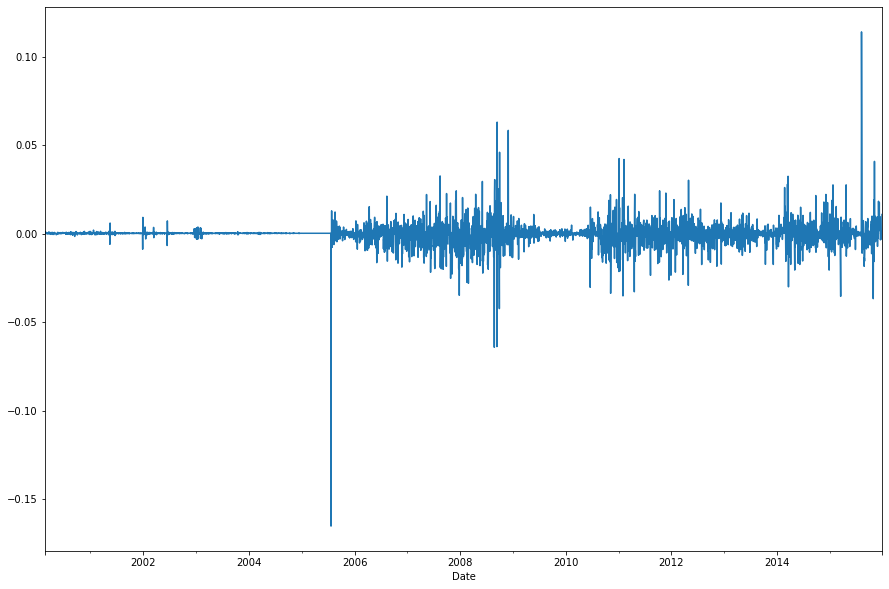

In [98]:
fig, ax = plt.subplots(figsize=(15, 10))
y_train_resid = model.resid
y_train_resid.plot(ax=ax)
plt.savefig("auto3.png")

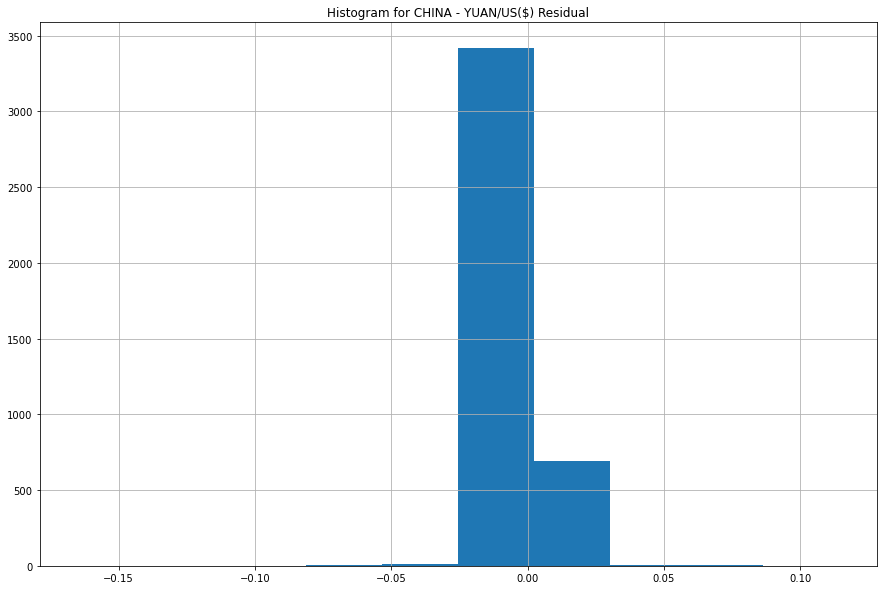

In [99]:
fig, ax = plt.subplots(figsize=(15, 10))
y_train_resid.hist(ax=ax)
plt.title("Histogram for CHINA - YUAN/US($) Residual")
plt.savefig("auto4.png")

The histogram above shows that our histogram almost follows a normal distribution

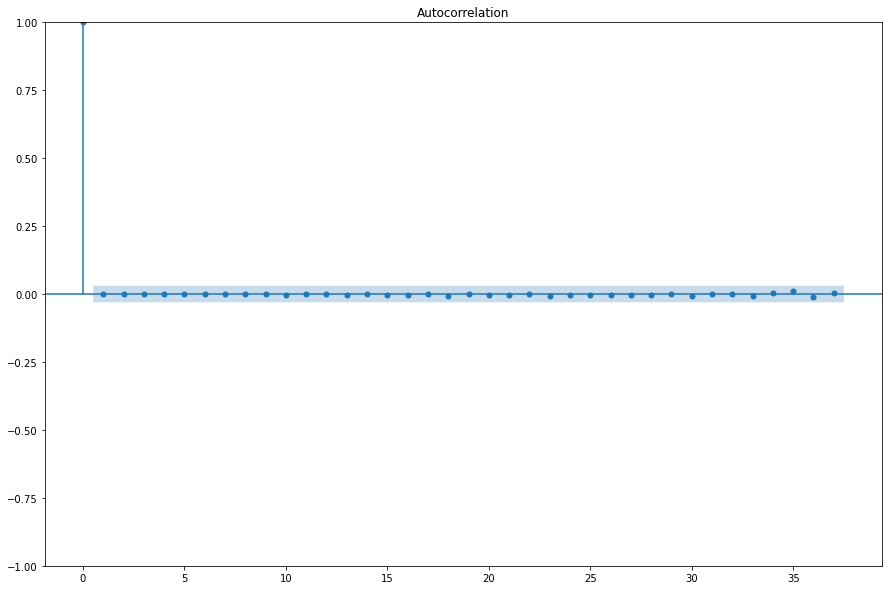

In [24]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_acf(y_train_resid, ax=ax);

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



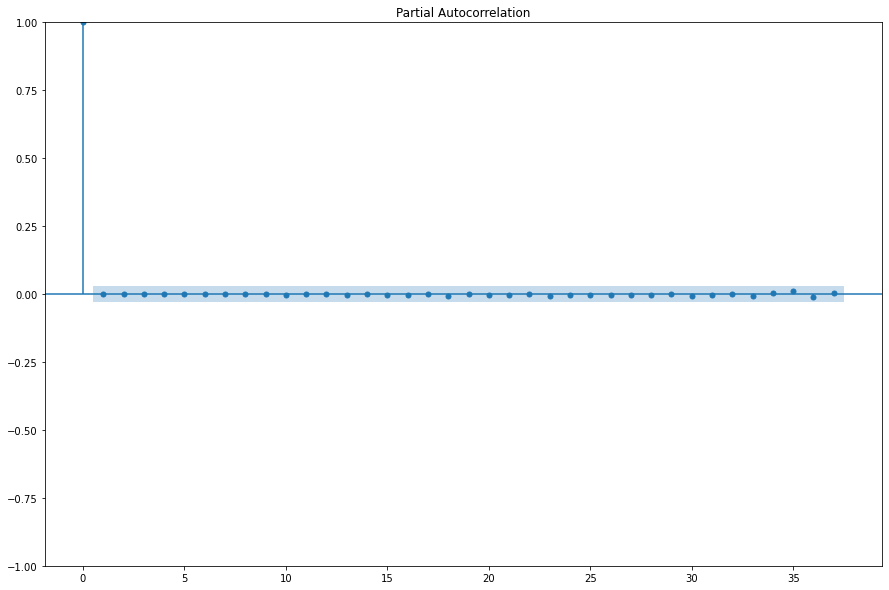

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_pacf(y_train_resid, ax=ax);

Plot_acf and pacf shows no predictive power when lag of 35 was used

In [26]:
y_pred_test = model.predict(y_test.index.min(), y_test.index.max())
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mae

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



0.37504410278193084

In [27]:
df_pred_test = pd.DataFrame({"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index)
px.line(df_pred_test, labels={"value": "pi"})

The graph above shows that our predictions did not follow the trend. 
So we will consider using hyperparameter tuning to find the suitable P value and use walk-forward validation for our prediction

#### Hyperparameter tuning

In [28]:
import time
p_params = range(1, 38)
maes = []
for p in p_params:
    start_time = time.time()
    model = AutoReg(y_train, lags=p).fit()
    elapsed_time = round(time.time() - start_time, 2)
    
    y_pred = model.predict().dropna()
    training_mae = mean_absolute_error(y_train.iloc[p:], y_pred)
    
    maes.append(training_mae)

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was

In [29]:
min(maes)

0.0031809872773618146

In [30]:
maes[25] == min(maes)

True

#### Walk Forward Validation

In [31]:
%%capture
y_pred_wfv = pd.Series()
history = y_train.copy()

for  i in range (len(y_test)):
    model = AutoReg(history, lags=25).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
print(y_pred_wfv)
print(history)

In [32]:
ar_mae_test = mean_absolute_error(y_test, y_pred_test)
ar_rss = np.sum(np.square(y_test - y_pred_test))
ar_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
ar_r2_score = r2_score(y_test, y_pred_test)
    
print(f"MAE for AutoRegressive model is {ar_mae_test.round(4)}")
print(f"RSS for AutoRegressive model is {ar_rss.round(4)}, RSME is {ar_rmse.round(4)}, and r2_score is {ar_r2_score.round(4)}")

MAE for AutoRegressive model is 0.375
RSS for AutoRegressive model is 215.5245, RSME is 0.4544, and r2_score is -3.6633


With hyyperparameter tuning and walk forward validation, our Autoregressive model performed better

### ARIMA model

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.statespace.varmax import VARMAX
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

In [34]:
df_arima = wrangle_1("Foreign_Exchange_Rates.xlsx", "CHINA - YUAN/US$")
df_arima.head()

Date
2000-01-03    8.2798
2000-01-04    8.2799
2000-01-05    8.2798
2000-01-06    8.2797
2000-01-07    8.2794
Name: CHINA - YUAN/US$, dtype: float64

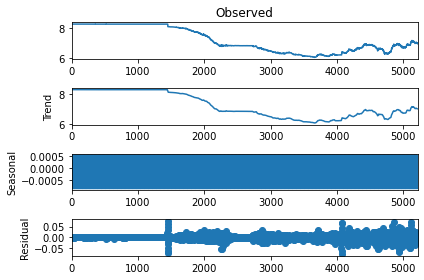

In [133]:
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.api as sm
#rcParams['figure.figsize'] = 11, 9
decomposed_currency = sm.tsa.seasonal_decompose(df_arima.values,  period=12) # The frequncy is annual
figure = decomposed_currency.plot()
plt.show()

In [36]:
cutoff = int(len(df_arima.values)*0.8)

y_train = df_arima.iloc[:cutoff]
y_test = df_arima.iloc[cutoff:]

len(y_train), len(y_test)

(4173, 1044)

In [37]:
import time
p_params = range(0, 20, 5)
q_params = range(0, 3, 1)

In [38]:
mae_grid = {}
for p in p_params:
    mae_grid[p] = []
     
    for q in q_params:
        order = (p, 0, q)
        start_time = time.time()
        
        model = ARIMA(y_train, order=order).fit()
        elapsed_time = round(time.time() - start_time, 2)
        
        print(f"Trained Arima model {order} in {elapsed_time} seconds.")
        
        y_pred = model.predict()
        
        mae = mean_absolute_error(y_train, y_pred)
        mae_grid[p].append(mae)

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



Trained Arima model (0, 0, 0) in 7.71 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Trained Arima model (0, 0, 1) in 10.96 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



Trained Arima model (0, 0, 2) in 23.56 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



Trained Arima model (5, 0, 0) in 11.5 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



Trained Arima model (5, 0, 1) in 25.58 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained Arima model (5, 0, 2) in 26.89 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



Trained Arima model (10, 0, 0) in 60.46 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



Trained Arima model (10, 0, 1) in 104.93 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained Arima model (10, 0, 2) in 65.91 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



Trained Arima model (15, 0, 0) in 132.81 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



Trained Arima model (15, 0, 1) in 239.28 seconds.


C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

C:\Users\owner\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



Trained Arima model (15, 0, 2) in 161.35 seconds.


In [39]:
# Getting the MAE values of trained arima model
df_mae = pd.DataFrame(mae_grid)
df_mae

,0,5,10,15
0,0.827938,0.003317,0.003327,0.003327
1,0.415223,0.003322,0.003359,0.003353
2,0.219941,0.003388,0.003347,0.003343


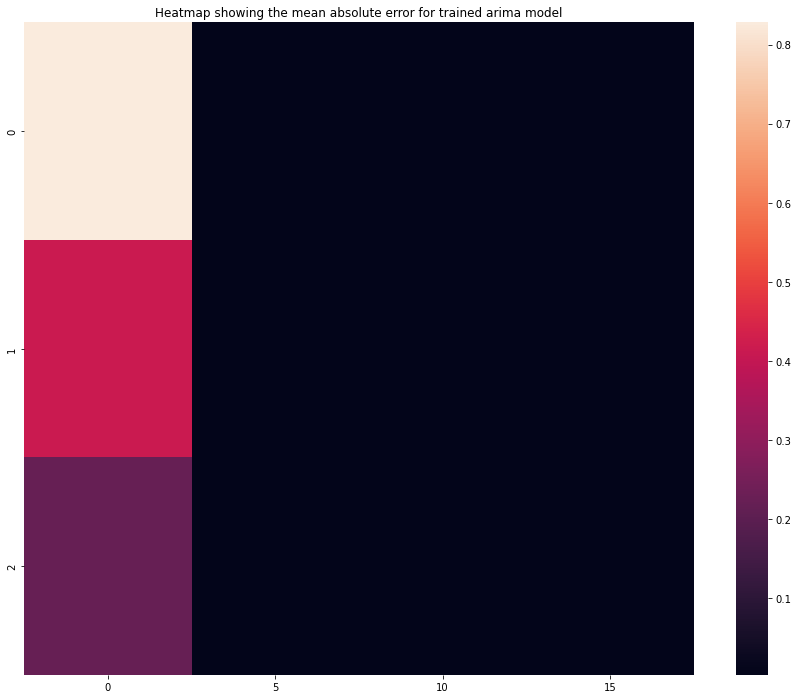

In [103]:
# Using seaborn to show the MAE values for Trained Arima
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(df_mae)
plt.title("Heatmap showing the mean absolute error for trained arima model")
plt.savefig("auto5.png")

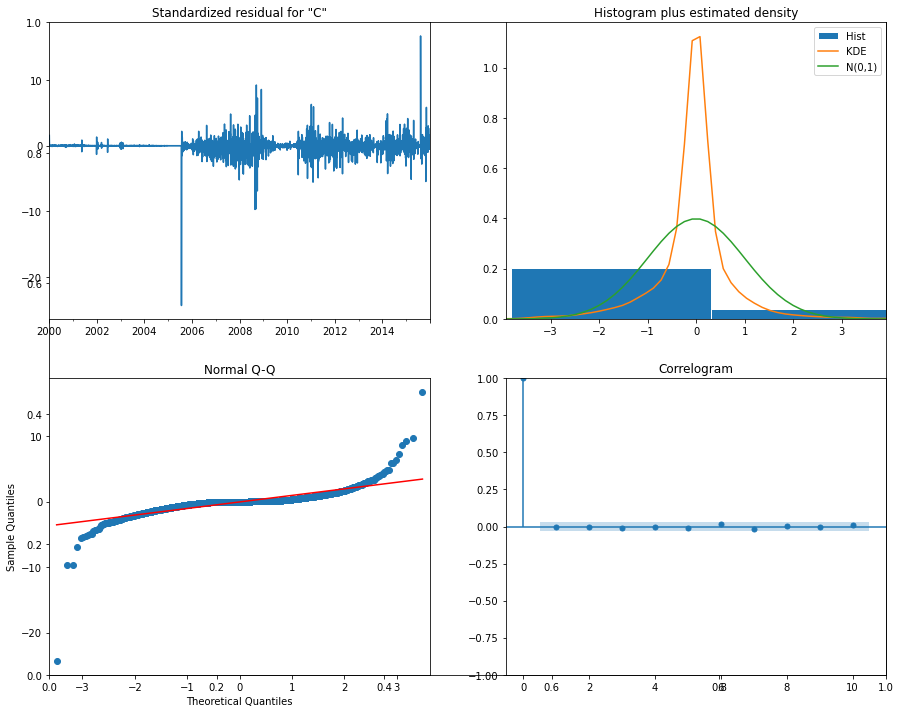

In [42]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);
plt.savefig("auto5.png")

The histogram above shows a normal distributiona and the correlogram shows that our lag values has no predictive strength.

#### Walk Forward Validation

In [43]:
%%capture
y_pred_wfv = pd.Series()
history = y_train.copy()    
for  i in range (len(y_test)):
    model = ARIMA(history, order = (5, 0, 0)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

y_pred_wfv

In [ ]:
y_pred_wfv

In [45]:
len(y_pred_wfv)

1044

In [46]:
arima_mae_test = mean_absolute_error(y_test, y_pred_wfv)
arima_rss = np.sum(np.square(y_test - y_pred_wfv))
arima_rmse = np.sqrt(mean_squared_error(y_test, y_pred_wfv))
arima_r2_score = r2_score(y_test, y_pred_wfv)
    
print(f"MAE for ARIMA model is {arima_mae_test.round(4)}")
print(f"RSS for ARIMA model is {arima_rss.round(4)}, RSME is {arima_rmse.round(4)}, and r2_score is {arima_r2_score.round(4)}")

MAE for ARIMA model is 0.0108
RSS for ARIMA model is 0.2733, RSME is 0.0162, and r2_score is 0.9941


In [49]:
df_prediction = pd.DataFrame({"y_test": y_test, "y_pred": y_pred_wfv}, index=y_test.index)
px.line(df_prediction, labels={"value": "pi"})

### Model Deployment/Inference

In [59]:
model_result = pd.DataFrame({"MAE":{"Linear": mae_test, "AR_model": ar_mae_test, "ARIMA": arima_mae_test}, 
                             "RSS": {"Linear":rss, "AR_model": ar_rss, "ARIMA": arima_rss}, 
                             "RMSE":{"Linear": rmse, "AR_model": ar_rmse, "ARIMA": arima_rmse}, 
                             "r2_score": {"Linear": r2_score, "AR_model": ar_r2_score, "ARIMA": arima_r2_score}})

In [60]:
model_result

,MAE,RSS,RMSE,r2_score
Linear,0.010836,0.273670,0.016191,0.994079
AR_model,0.375044,215.524511,0.454358,-3.663285
ARIMA,0.010807,0.273345,0.016181,0.994086


- **The difference between the performance metrics of Linear Regression and ARIMA is small (which can be slightly negliglible).**

- **Although ARIMA gave the best performance (with walk forward validation), however it has high run time.**

- **Therefore, Linear Regression is selected for faster prediction and deployment.**

In [79]:
def make_prediction(currency, currency_value):
    df = wrangle("Foreign_Exchange_Rates.xlsx", currency)
    
    #Split dataset
    X = df.drop(columns=df.columns[0])
    y = df[df.columns[0]]
   
    #Train-test-split
    cut_off = int(len(X)*0.8)
    X_train, y_train = X.iloc[:cut_off], y.iloc[:cut_off]
    X_test, y_test = X.iloc[cut_off:], y.iloc[cut_off:]
    
    #Instatiate model and fit
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #Model evaluation: Performance metrics
    y_pred_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rss = np.sum(np.square(y_test - y_pred_test))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    #r2 = r2_score(y_test, y_pred_test)
    
    print(f"MAE is {mae_test.round(6)}, RSS is {rss.round(6)}, RSME is {rmse.round(6)}")
    
    
    #Communicating Results: intercept and coefficient  
    intercept = round(model.intercept_, 6)
    coefficient = round(model.coef_[0], 6)
    
    prediction = intercept + (coefficient * currency_value)
    
    return f"Predicted Price for {df.columns[0]}: {prediction}"

In [80]:
make_prediction("CHINA - YUAN/US$", 8.2797)

C:\Users\owner\AppData\Local\Temp\ipykernel_8824\224743042.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MAE is 0.010836, RSS is 0.27367, RSME is 0.016191


C:\Users\owner\AppData\Local\Temp\ipykernel_8824\224743042.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'Predicted Price for YUAN/US$: 8.2792047007'

### Using our model to predict other currency

In [135]:
# Making Prediction for AUSTRALIAN DOLLAR/USD
make_prediction("AUSTRALIA - AUSTRALIAN DOLLAR/US$", 1.5272)

C:\Users\owner\AppData\Local\Temp\ipykernel_8824\224743042.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\owner\AppData\Local\Temp\ipykernel_8824\224743042.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MAE is 0.005344, RSS is 0.054878, RSME is 0.00725


'Predicted Price for AUSTRALIAN DOLLAR/US$: 1.5270086751999998'

In [136]:
# Making Prediction for AUSTRALIAN DOLLAR/USD
make_prediction("EURO AREA - EURO/US$", 0.9686)

C:\Users\owner\AppData\Local\Temp\ipykernel_8824\224743042.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MAE is 0.002805, RSS is 0.015515, RSME is 0.003855


C:\Users\owner\AppData\Local\Temp\ipykernel_8824\224743042.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



'Predicted Price for EURO/US$: 0.9684695957999999'